# Data Loading and DataFrame/DataSeries Generation

We're going to load all the image data into an xarray data series object.  We'll also do some image manipulation to make sure everything is the same size (via downsampling), and we'll try to grab some metadata out of the DICOM info.  This might get trickier as future data may be 

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import SimpleITK as sitk
import sys, os
import numpy as np
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
%matplotlib notebook
import os
import pickle as pkl
from skimage import morphology


In [2]:
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subjects = sorted([x for x in os.listdir(full_data_dir) if x.isdigit()])
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
sequence_labels = ['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast']
extras = ['extra1', 'extra2', 'extra3', 'extra4']

In [5]:
reference_origin = np.zeros(3)
reference_direction = np.identity(3).flatten()
reference_size = [300, 300, 4]
reference_spacing = [1.4,1.4,10] #1.3mm x 1.3mm x 10mm

reference_image = sitk.Image(reference_size, 2)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)
reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))


In [ ]:
sitk.Transform

size (512, 512, 4)
dims (0.7422, 0.7422, 11.49998950958252)
dimension 3
pixIDvalue 2
origin (-164.39100646972656, -235.6909942626953, 9.956210136413574)
new size (300, 300, 4)
new dims (1.4, 1.4, 11.49998950958252)
new origin (0.0, 0.0, 0.0)

size (512, 512, 4)
dims (0.7422, 0.7422, 11.49998950958252)
dimension 3
pixIDvalue 2
origin (-164.39100646972656, -235.6909942626953, 9.956210136413574)
new size (300, 300, 4)
new dims (1.4, 1.4, 11.49998950958252)
new origin (0.0, 0.0, 0.0)

size (256, 256, 4)
dims (1.4844, 1.4844, 12.0)
dimension 3
pixIDvalue 2
origin (-159.5279998779297, -240.00799560546875, -6.7218098640441895)
new size (300, 300, 4)
new dims (1.4, 1.4, 12.0)
new origin (0.0, 0.0, 0.0)

size (256, 256, 4)
dims (1.4844, 1.4844, 8.999999046325684)
dimension 3
pixIDvalue 2
origin (-159.5279998779297, -240.00799560546875, 13.710000038146973)
new size (300, 300, 4)
new dims (1.4, 1.4, 8.999999046325684)
new origin (0.0, 0.0, 0.0)

size (256, 256, 4)
dims (1.4844, 1.4844, 11.0000400

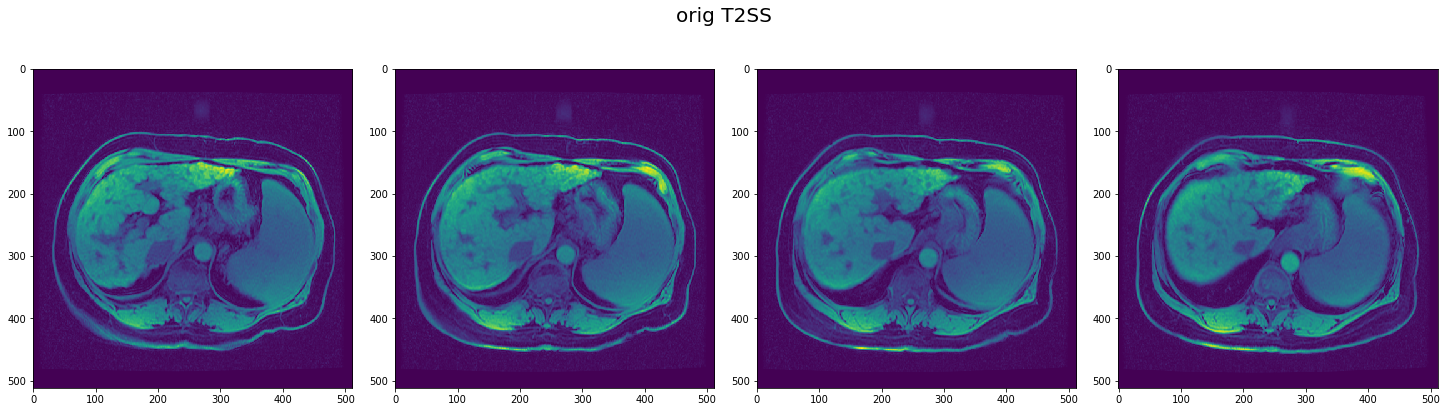

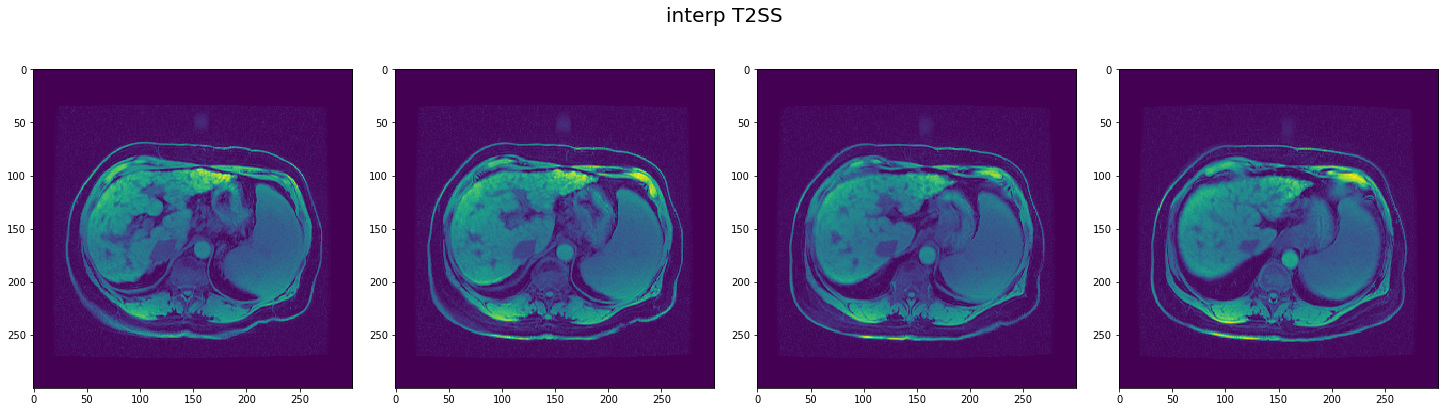

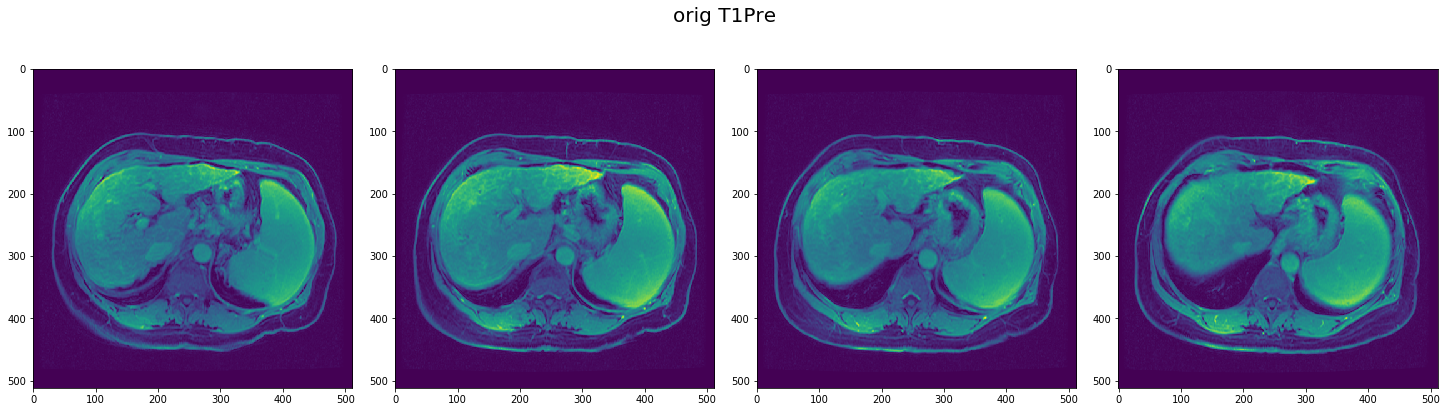

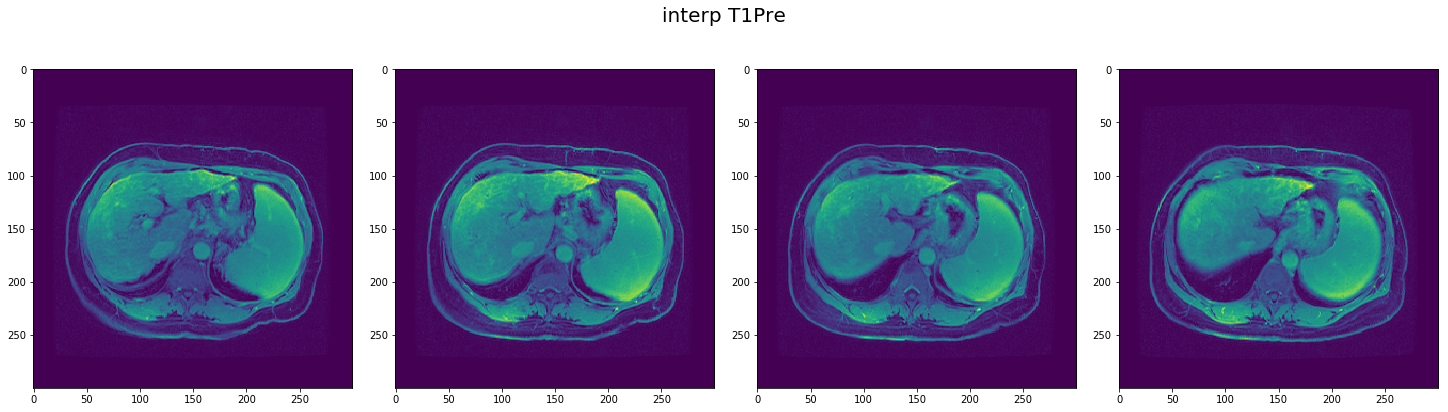

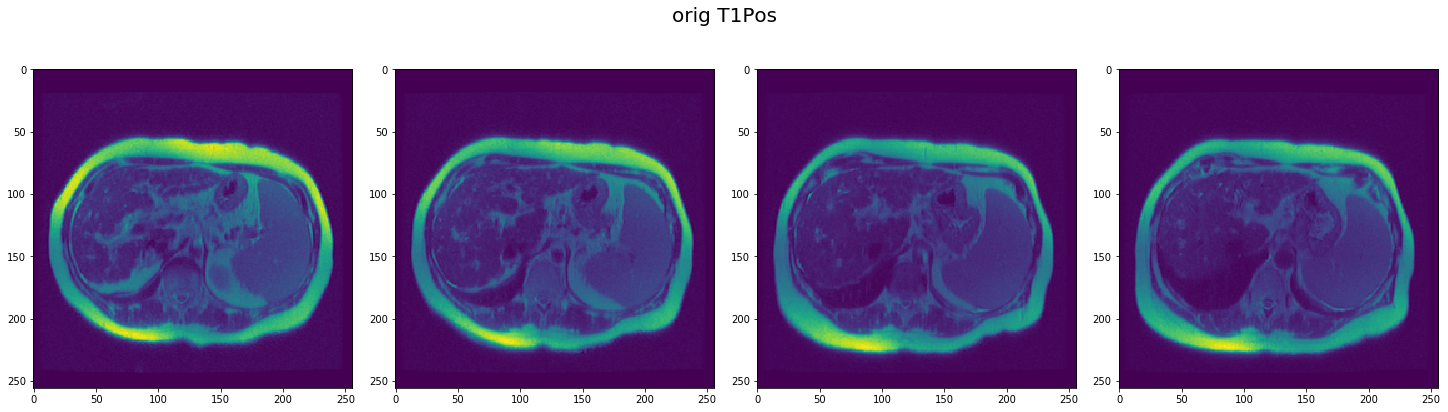

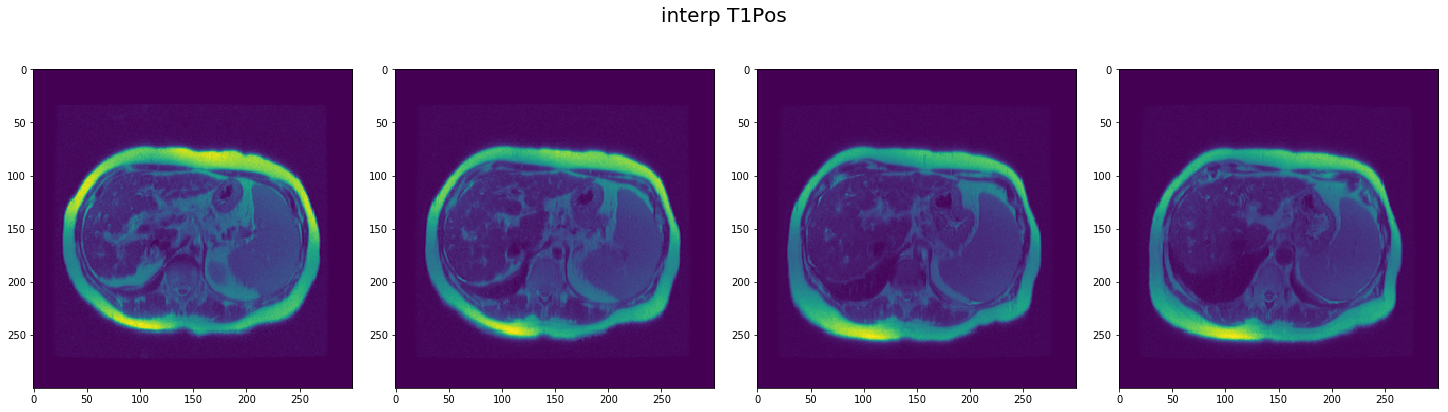

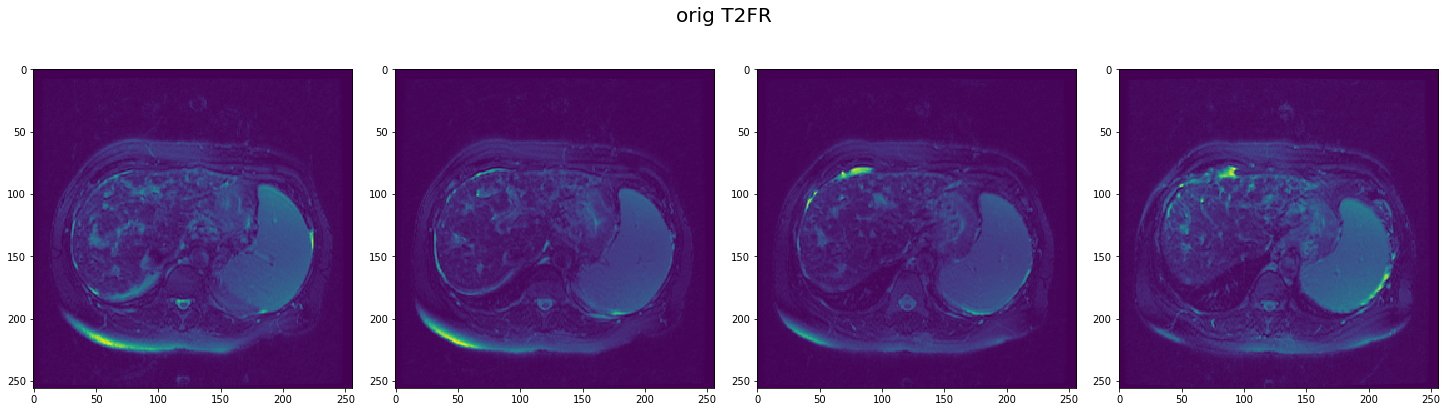

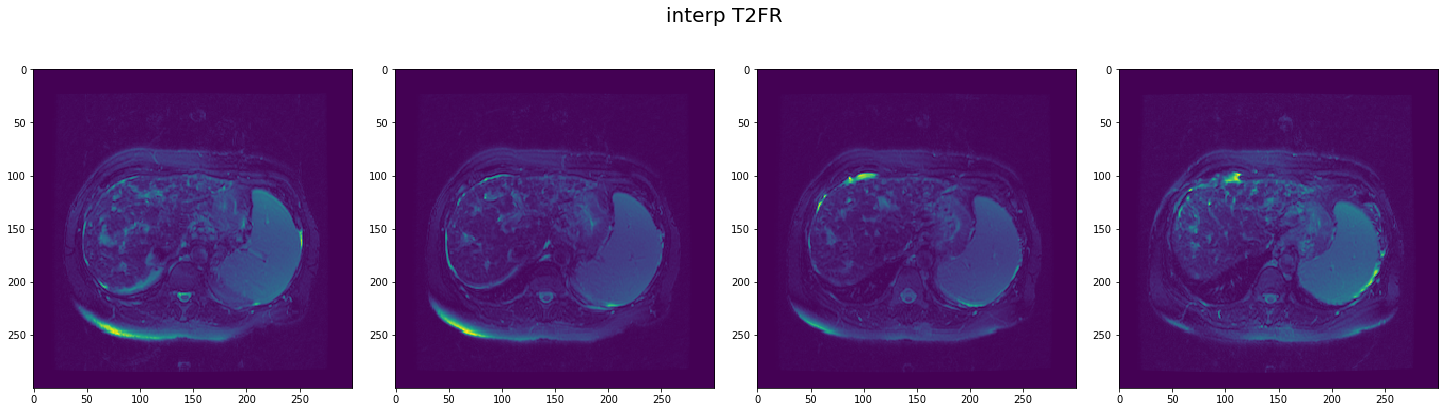

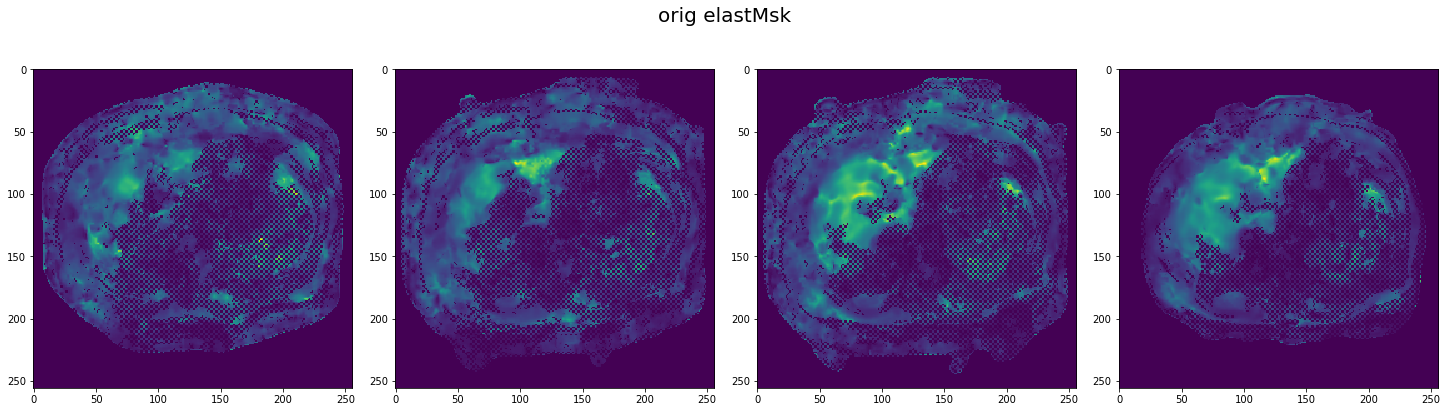

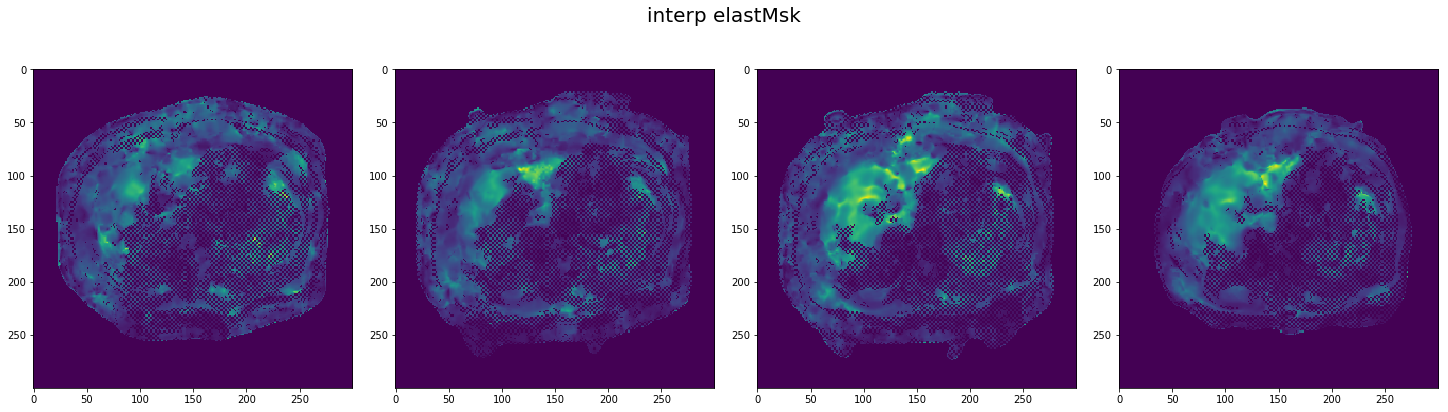

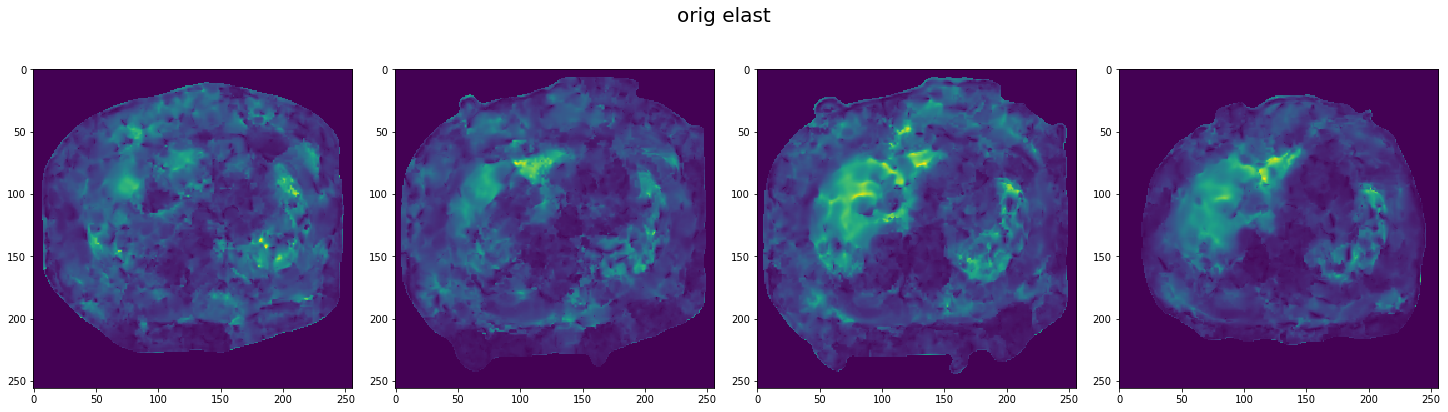

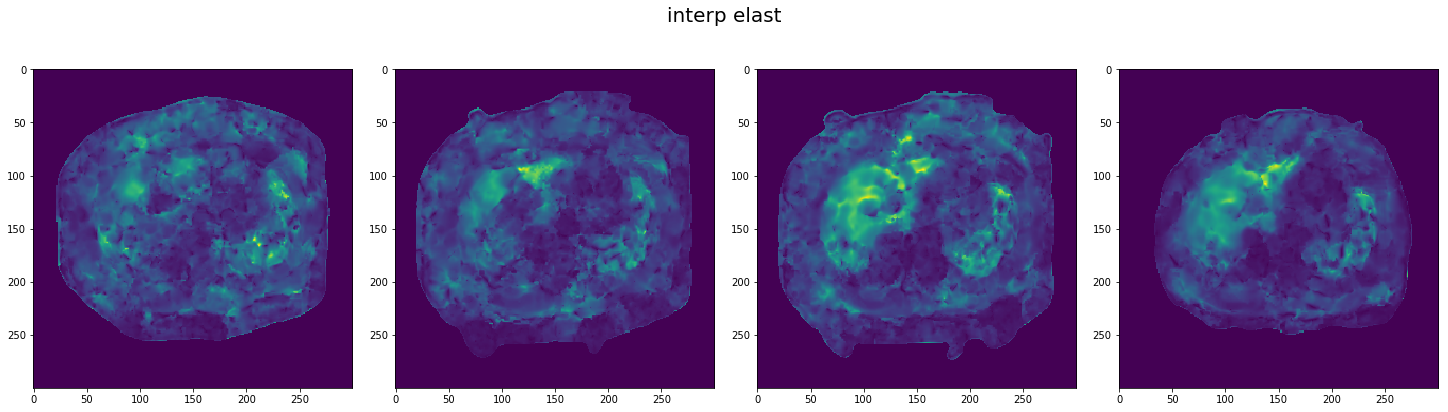

In [6]:
verbose = True
new_ds = False
do_extras = False
subj_age = []
images = []
if do_extras:
    add_extra = extras
else:
    add_extra = []
#for subj in subjects: 
for subj in ['403']: 
    images.append([])
    data_dir = full_data_dir + f'/{subj}/DICOM/ST00001'
    for i,fn in enumerate(subdir_names+add_extra):
    #for i,fn in enumerate(['SE00005']):
        #print( "Reading Dicom directory:", data_dir )
        if 'extra' in fn:
            images[-1].append(np.zeros([4,256,256]))
        else:
            reader = sitk.ImageSeriesReader()
            dicom_names = reader.GetGDCMSeriesFileNames( data_dir + '/' + fn )
            reader.SetFileNames(dicom_names)
            reader.MetaDataDictionaryArrayUpdateOn() # Get DICOM Info
            reader.LoadPrivateTagsOn() #Get DICOM Info

            image = reader.Execute()
            size = image.GetSize()
            dims = image.GetSpacing()
            dimension = image.GetDimension()
            if verbose: 
                print('size', size)
                print('dims', dims)
                print('dimension', dimension)
                print('pixIDvalue', image.GetPixelIDValue())
                print('origin', image.GetOrigin())
            #IMG = skim.transform.resize(sitk.GetArrayFromImage(image), (size[-1],256,256)) #Downsample image if too big
            #affine = sitk.AffineTransform(3)
            #affine.Scale((0.5, 0.5, 1))
            transform = sitk.AffineTransform(3)
            transform.SetMatrix(image.GetDirection())
            transform.SetTranslation(np.array(image.GetOrigin()) - reference_origin)

            centering_transform = sitk.TranslationTransform(3)
            img_center = np.array(image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize())/2.0))
            centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
            centered_transform = sitk.Transform(transform)
            centered_transform.AddTransform(centering_transform)

            reference_image.SetSpacing([1.4,1.4,dims[-1]])
            #reference_image.SetSpacing([1.3,1.3,15])
            #reference_image.SetOrigin(image.GetOrigin())
            new_image = sitk.Resample(image, reference_image, centered_transform, sitk.sitkNearestNeighbor)
            size = new_image.GetSize()
            dims = new_image.GetSpacing()
            if verbose:
                print('new size', size)
                print('new dims', dims)
                print('new origin', new_image.GetOrigin())
                print()
                fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(20,6), sharex=False, sharey=False)
                axs = axs.flatten()
                axs[0].imshow(sitk.GetArrayFromImage(image)[0,:,:])
                axs[1].imshow(sitk.GetArrayFromImage(image)[1,:,:])
                axs[2].imshow(sitk.GetArrayFromImage(image)[2,:,:])
                axs[3].imshow(sitk.GetArrayFromImage(image)[3,:,:])
                fig.suptitle('orig '+sequence_labels[i], size=20)
                fig, axs = plt.subplots(1, 4, constrained_layout=True, figsize=(20,6), sharex=False, sharey=False)
                axs = axs.flatten()
                axs[0].imshow(sitk.GetArrayFromImage(new_image)[0,:,:])
                axs[1].imshow(sitk.GetArrayFromImage(new_image)[1,:,:])
                axs[2].imshow(sitk.GetArrayFromImage(new_image)[2,:,:])
                axs[3].imshow(sitk.GetArrayFromImage(new_image)[3,:,:])
                fig.suptitle('interp '+sequence_labels[i], size=20)
            #if IMG.shape[0] != 4:
            #    print('WARNING, MORE THAN 4 SLICES')
            #    print(data_dir + '/' + fn)
            images[-1].append(sitk.GetArrayFromImage(new_image))
        if i==0:
            subj_age.append(reader.GetMetaData(0,'0010|0030'))
if new_ds:
    images = np.asanyarray(images)
    subj_age = [2018-int(a[0:4]) for a in subj_age]
    ds = xr.Dataset({'images': (['subject', 'sequence', 'slices', 'y', 'x'], images),
                    'ages':(['subject'], subj_age)},
                    coords={'subject': subjects,
                            'sequence':sequence_labels+add_extra})
    pkl.dump(ds, open(full_data_dir+'mre_ds_transform_1.p', 'wb'), protocol=-1)

In [102]:
ds

<xarray.Dataset>
Dimensions:   (sequence: 10, slices: 4, subject: 20, x: 256, y: 256)
Coordinates:
  * subject   (subject) <U3 '365' '368' '370' '371' ... '403' '404' '405' '406'
  * sequence  (sequence) <U8 'T2SS' 'T1Pre' 'T1Pos' ... 'extra3' 'extra4'
Dimensions without coordinates: slices, x, y
Data variables:
    images    (subject, sequence, slices, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0
    ages      (subject) int64 58 60 58 74 73 64 38 76 ... 70 37 63 63 56 44 50

In [17]:
ds = pkl.load(open(full_data_dir+'mre_ds_1.p', 'rb'))

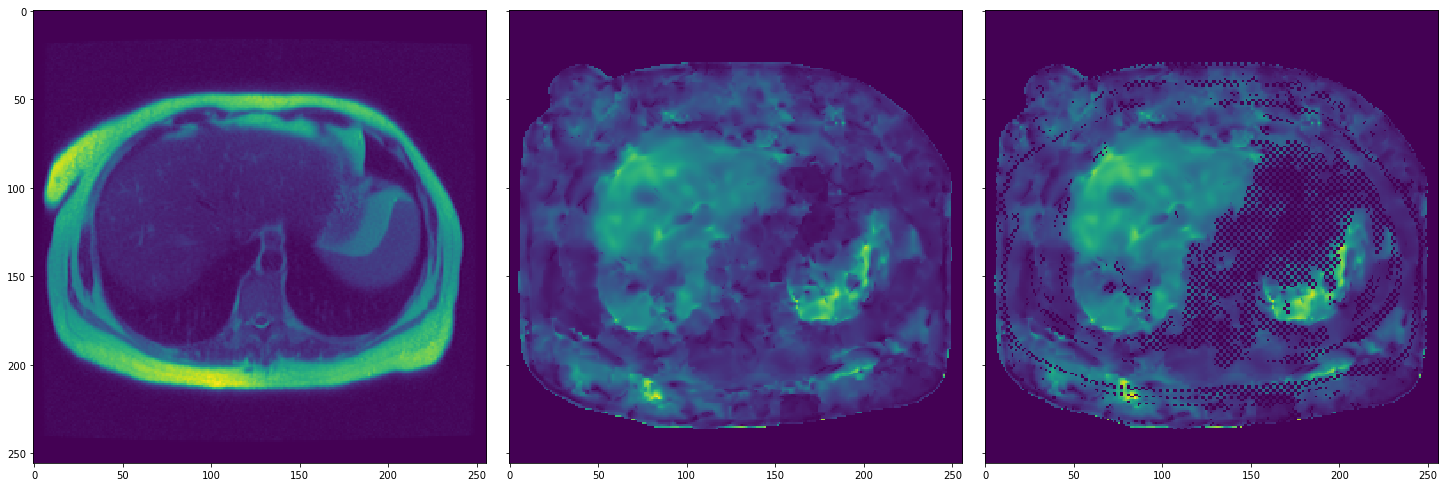

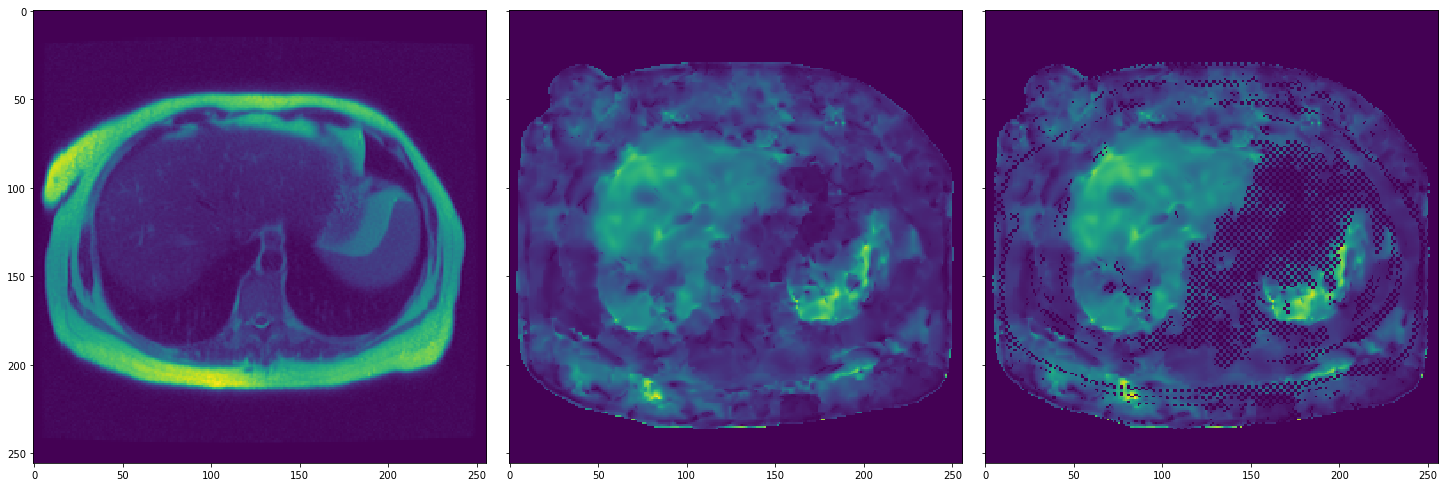

In [97]:
#ds.sel(subject='365', sequence='T2SS').std(dim='slices').images.plot(size=10, yincrease=False)
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(20,10), sharex=True, sharey=True)
axs = axs.flatten()
subj = '405'
slc = 2
axs[0].imshow(ds.sel(subject=subj, sequence='T1Pos', slices=slc).images)
axs[1].imshow(ds.sel(subject=subj, sequence='elast', slices=slc).images)
axs[2].imshow(ds.sel(subject=subj, sequence='elastMsk', slices=slc).images)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(20,10), sharex=True, sharey=True)
axs = axs.flatten()
axs[0].imshow(ds_new.sel(subject=subj, sequence='T1Pos', slices=slc).images)
axs[1].imshow(ds_new.sel(subject=subj, sequence='elast', slices=slc).images)
axs[2].imshow(ds_new.sel(subject=subj, sequence='elastMsk', slices=slc).images)
#ds.sel(subject='365', sequence='elast', slices=1).images.plot(yincrease=False, robust=False, ax=axs[1])
#ds.sel(subject='365', sequence='elastMsk', slices=1).images.plot(yincrease=False, robust=False, ax=axs[2])

In [ ]:
ds.sel(sequence='elastMsk', slices=1).images.plot(yincrease=False, col='subject', robust = True, col_wrap=4, size=10)

In [ ]:
ds.ages.plot.hist()

In [ ]:
str(ds.subject[0].values)

In [ ]:
fig, axs = plt.subplots(5, 4, constrained_layout=True, figsize=(25,30), sharex=True, sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.imshow(ds.sel(sequence='elastMsk', slices=3, subject=ds.subject[i]).images)
    ax.set_title(str(ds.subject[i].values))

In [ ]:
single_image = ds.sel(slices=1, sequence='T2SS', subject='365').images
fig = plt.figure(figsize=(10,8))
plt.imshow(single_image)

In [ ]:
ds.sel(slices=1, sequence='T2SS').ages